# Распознавания автомобильных номеров. 


In [1]:
# Скачиваем датасет с каггла
!curl -L https://www.dropbox.com/s/gspmlprf7bm8hs0/kaggle.json?dl=0 -o kaggle.json
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list --mine
!kaggle datasets download -d slayzar/ocr-dataset
!unzip ocr-dataset.zip
!rm ocr-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/train/55.bmp       
  inflating: data/train/550.jpg      
  inflating: data/train/5500.jpg     
  inflating: data/train/5501.bmp     
  inflating: data/train/5502.jpg     
  inflating: data/train/5503.jpg     
  inflating: data/train/5504.jpg     
  inflating: data/train/5505.jpg     
  inflating: data/train/5506.jpg     
  inflating: data/train/5507.jpg     
  inflating: data/train/5508.jpg     
  inflating: data/train/5509.jpg     
  inflating: data/train/551.jpg      
  inflating: data/train/5510.jpg     
  inflating: data/train/5511.jpg     
  inflating: data/train/5512.jpg     
  inflating: data/train/5513.jpg     
  inflating: data/train/5514.jpg     
  inflating: data/train/5515.jpg     
  inflating: data/train/5516.jpg     
  inflating: data/train/5517.jpg     
  inflating: data/train/5518.jpg     
  inflating: data/train/5519.bmp     
  inflating: data/train/552.jpg      
  inflating: data/train/5520.jpg     

In [2]:
import os
import gc
import json
import glob
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import seaborn as sns
import tqdm

from tqdm import tqdm_notebook
import torchvision
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision import transforms

import PIL
from PIL import Image, ImageDraw
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
torch.__version__, torch.cuda.is_available()

('1.5.0+cu101', True)

### Сейчас будет много вспомогательных функций, которые можно промотать

Чтобы было наглядно и не приходилось лезть в модули, чтобы посмотреть, какая функция что делает, оставил для наглядности пока что все в ноутбуке. Можно аккуратно перенести в модули :)

In [0]:
# Бинарный поиск для приближения предсказанной маски 4-хугольником
def simplify_contour(contour, n_corners=4):
    n_iter, max_iter = 0, 1000
    lb, ub = 0., 1.

    while True:
        n_iter += 1
        if n_iter > max_iter:
            print('simplify_contour didnt coverege')
            return None

        k = (lb + ub)/2.
        eps = k*cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, eps, True)

        if len(approx) > n_corners:
            lb = (lb + ub)/2.
        elif len(approx) < n_corners:
            ub = (lb + ub)/2.
        else:
            return approx

# Отображаем 4-хугольник в прямоугольник 
# Спасибо ulebok за идею 
# И вот этим ребятам за реализацию: https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
def four_point_transform(image, pts):
    
    rect = order_points(pts)
    
    tl, tr, br, bl = pts
    
    width_1 = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width_2 = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    max_width = max(int(width_1), int(width_2))
    
    height_1 = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height_2 = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = max(int(height_1), int(height_2))
    
    dst = np.array([
        [0, 0],
        [max_width, 0],
        [max_width, max_height],
        [0, max_height]], dtype = "float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (max_width, max_height))
    return warped

def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect


# Визуализируем детекцию (4 точки, bounding box и приближенный по маске контур)
def visualize_prediction_plate(file, model, device='cuda', verbose=True, thresh=0.0, 
                               n_colors=None, id_to_name=None):
    img = Image.open(file)
    img_tensor = my_transforms(img)
    model.to(device)
    model.eval()
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]
    
    if n_colors is None:
        n_colors = model.roi_heads.box_predictor.cls_score.out_features
    
    palette = sns.color_palette(None, n_colors)
    
    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    image = img
    
    blackImg = np.zeros(image.shape, image.dtype)
    blackImg[:,:] = (0, 0, 0)
    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()
        name = id_to_name[label]
        color = palette[label]
        
        if verbose:
            if score > thresh:
                print ('Class: {}, Confidence: {}'.format(name, score))
        if score > thresh:            
            crop_img = image[y_min:y_max, x_min:x_max]
            print('Bounding box:')
            show_image(crop_img, figsize=(10, 2))
            
            contours, _ = cv2.findContours((mask > 0.05).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
#                 points = [[x_min, y_min], [x_min, y_max], [x_max, y_min],[x_max, y_max]]
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]
            
            
            points = np.array(points)
            crop_mask_img = four_point_transform(img, points)
            print('Rotated img:')
            crop_mask_img = cv2.resize(crop_mask_img, (320, 64), interpolation=cv2.INTER_AREA)
            show_image(crop_mask_img, figsize=(10, 2))
            if approx is not None:
                cv2.drawContours(image, [approx], 0, (255,0,255), 3)
            image = cv2.circle(image, (x0, y0), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x1, y1), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x2, y2), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x3, y3), radius=5, color=(0, 0, 255), thickness=-1)
            
            image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), np.array(color) * 255, 2)
            
    show_image(image)
    return prediction

# Просто показать картинку. С семинара
def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[...,::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()
    

# Переводит предсказания модели в текст. С семинара
def decode(pred, alphabet):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], alphabet))
    return outputs

def pred_to_string(pred, alphabet):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([alphabet[c] for c in out])
    return out
    

        
def load_json(file):
    with open(file, 'r') as f:
        return json.load(f)
    
# Чтобы без проблем сериализовывать json. Без него есть нюансы
class npEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.int32):
            return int(obj)
        return json.JSONEncoder.default(self, obj)

In [0]:
abc = "0123456789ABEKMHOPCTYXСВХАОВТКЕМОРН"
from string import digits

def compute_mask(text):
    """Compute letter-digit mask of text.
    Accepts string of text. 
    Returns string of the same length but with every letter replaced by 'L' and every digit replaced by 'D'.
    e.g. 'E506EC152' -> 'LDDDLLDDD'.
    Returns None if non-letter and non-digit character met in text.
    """
    mask = []
    for char in text.upper():
        if char in digits:
            mask.append("D")
        elif char in abc:
            mask.append("L")
        else:
            return None
    return "".join(mask)

def check_in_alphabet(text, alphabet=abc):
    """Check if all chars in text come from alphabet.
    Accepts string of text and string of alphabet. 
    Returns True if all chars in text are from alphabet and False else.
    """
    for char in text.upper():
        if char not in alphabet:
            return False
    return True

def filter_data(config):
    """Filter config keeping only items with correct text.
    Accepts list of items.
    Returns new list.
    """
    config_filtered = []
    for item in config:
        text = item['nums'][0]["text"].upper()
        mask = compute_mask(text)
        if check_in_alphabet(text) and (mask == "LDDDLLDD" or mask == "LDDDLLDDD"):
            config_filtered.append({"file": item["file"],
                                   "nums": item['nums']
                                    })
    return config_filtered

In [0]:
DATA_PATH = './data/'
TRAIN_SIZE = 0.9
BATCH_SIZE = 2
BATCH_SIZE_OCR = 8
DETECTOR_MODEL_PATH = 'detect_model.pt'
OCR_MODEL_PATH = 'ocr_model.pt'

all_marks = load_json(os.path.join(DATA_PATH, 'train.json'))
all_marks = filter_data(all_marks)
test_start = int(TRAIN_SIZE * len(all_marks))
train_marks = all_marks[:test_start]
val_marks = all_marks[test_start:]

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 1. Находим номера

### a) Модель для детекции

В задании есть данные о 4 точках, которые задают номер. Эти 4 точки - почти всегда не прямоугольник, а произвольный четырехугольник. Будем предсказывать:

- bounding box, который окружает точки (детекция)
- маску, заполненную тем, что внутри 4-х точек (сегментация)

Поэтому, возьмем maskrcnn. Будем обучать несколько последних солев. Этого с запасом хватает.

In [0]:
def get_detector_model():
    
    model = models.detection.maskrcnn_resnet50_fpn(
        pretrained=True, 
        pretrained_backbone=True,
        progress=True, 
        num_classes=91, 
    )

    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.roi_heads.box_predictor = box_predictor
    
    mask_predictor = MaskRCNNPredictor(256, 256, num_classes)
    model.roi_heads.mask_predictor = mask_predictor

    # Заморозим все слои кроме последних
    
    for param in model.parameters():
        param.requires_grad = False
        
    for param in model.backbone.fpn.parameters():
        param.requires_grad = True

    for param in model.rpn.parameters():
        param.requires_grad = True

    for param in model.roi_heads.parameters():
        param.requires_grad = True
    
    return model

### b) Датасет для детекции

In [0]:
class DetectionDataset(Dataset):
    def __init__(self, marks, img_folder, transforms=None):
        
        self.marks = marks
        self.img_folder = img_folder
        self.transforms = transforms
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = f'{self.img_folder}{item["file"]}'
        img = Image.open(img_path).convert('RGB')
        w, h = img.size
        
        box_coords = item['nums']
        boxes = []
        labels = []
        masks = []
        for box in box_coords:
            points = np.array(box['box'])  
            x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
            x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])
            boxes.append([x0, y0, x2, y2])
            labels.append(1)
            
            # Здесь мы наши 4 точки превращаем в маску
            # Это нужно, чтобы кроме bounding box предсказывать и, соответственно, маску :)
            nx, ny = w, h
            poly_verts = points
            x, y = np.meshgrid(np.arange(nx), np.arange(ny))
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x,y)).T
            path = Path(poly_verts)
            grid = path.contains_points(points)
            grid = grid.reshape((ny,nx)).astype(int)
            masks.append(grid)
            
        boxes = torch.as_tensor(boxes)
        labels = torch.as_tensor(labels)
        masks = torch.as_tensor(masks)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
        }
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, target
    
    
    def __len__(self):
        return len(self.marks)
    
my_transforms = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = DetectionDataset(
    marks=train_marks, 
    img_folder='data/', 
    transforms=my_transforms
)
val_dataset = DetectionDataset(
    marks=val_marks, 
    img_folder='data/', 
    transforms=my_transforms
)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=True,
    num_workers=4,
    collate_fn=collate_fn, 
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=False,
    num_workers=4,
    collate_fn=collate_fn, 
)

### c) Обучаем модель для детекции

In [10]:
torch.cuda.empty_cache()
gc.collect()
model = get_detector_model()
# model.load_state_dict(torch.load('detect_model.pth'))
model.to(device);

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


Валидироваться на чем-то нет смысла, ибо лосс перестает падать еще до того момента, как пройдет 1-я эпоха. Т.е. лосс на трейне вполне валидный, ибо модель видит данные в первый раз.

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, 
                                                       factor=0.5, verbose=True)

tr_loss = []
val_loss = []
cur_best_loss = np.inf
NUM_EPOCH = 1
model.train()
for epoch in range(NUM_EPOCH):
    print(f'Epoch {epoch}')
    print_loss = []
    for i, (images, targets) in tqdm.tqdm(enumerate(train_loader), leave=False, position=0, total=len(train_loader)):

        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss_dict.values())

        losses.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        print_loss.append(losses.item())
        if (i + 1) % 20 == 0:
          mean_loss = np.mean(print_loss)
          scheduler.step(mean_loss)
          if (i + 1) % 1000 == 0:
              print(f'Loss: {mean_loss:.7f}')
    tr_loss.append(mean_loss)

    model.eval()
    s = 0
    counter = 0
    val_loss = []
    for i, (images, targets) in tqdm.tqdm(enumerate(val_loader), leave=False, 
                                          position=0, total=len(val_loader)):

        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            loss_dict = model(images, targets)
        for i in range(len(loss_dict)):
          for val in loss_dict[i]['scores']: 
            s += 1 - val
            counter += 1
        
        val_loss.append(s/counter)

Epoch 0


  9%|▊         | 1000/11483 [05:38<1:03:52,  2.74it/s]

Loss: 0.2274774


 17%|█▋        | 2000/11483 [11:23<46:37,  3.39it/s]

Loss: 0.2052640


 26%|██▌       | 3000/11483 [17:07<51:17,  2.76it/s]

Loss: 0.1952831


 35%|███▍      | 4000/11483 [22:45<35:35,  3.50it/s]

Loss: 0.1892518


 44%|████▎     | 5000/11483 [28:23<34:36,  3.12it/s]

Loss: 0.1858735


 49%|████▉     | 5600/11483 [31:53<38:07,  2.57it/s]

Epoch   280: reducing learning rate of group 0 to 1.5000e-04.


 52%|█████▏    | 6000/11483 [34:05<31:09,  2.93it/s]

Loss: 0.1857334


 52%|█████▏    | 6020/11483 [34:12<25:29,  3.57it/s]

Epoch   301: reducing learning rate of group 0 to 7.5000e-05.


 61%|██████    | 7000/11483 [39:49<28:16,  2.64it/s]

Loss: 0.1806491


 70%|██████▉   | 8000/11483 [45:26<18:08,  3.20it/s]

Loss: 0.1770418


 78%|███████▊  | 9000/11483 [51:03<17:25,  2.38it/s]

Loss: 0.1742674


 87%|████████▋ | 10000/11483 [56:50<08:36,  2.87it/s]

Loss: 0.1721250


 96%|█████████▌| 11000/11483 [1:02:32<02:56,  2.74it/s]

Loss: 0.1700823


100%|█████████▉| 1275/1276 [06:06<00:00,  5.77it/s]

UnidentifiedImageError: ignored

In [13]:
print(f'Epoch {epoch} validation loss = {(sum(val_loss) / len(val_loss))}')
with open(f"detect_model.pth", "wb") as fp:
  torch.save(model.state_dict(), fp)

Epoch 0 validation loss = 0.17526398599147797


In [0]:
# torch.save(model.state_dict(), DETECTOR_MODEL_PATH)

In [0]:
model.load_state_dict(torch.load('detect_model.pth'))
model.to(device);

In [0]:
test_images = glob.glob(os.path.join(DATA_PATH, 'test/*'))

Class: plate, Confidence: 0.9994563460350037
Bounding box:


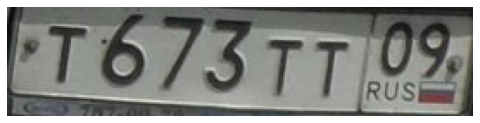

Rotated img:


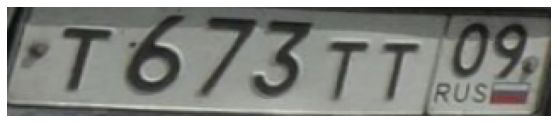

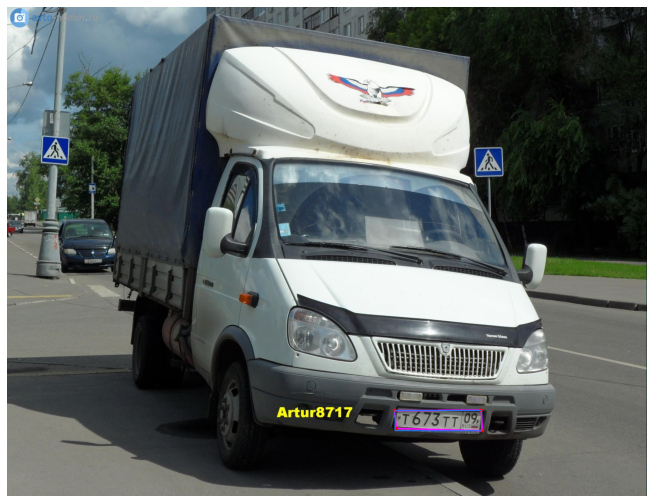

{'boxes': tensor([[1211.8014, 1261.2179, 1481.1576, 1324.4264]], device='cuda:0'),
 'labels': tensor([1], device='cuda:0'),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0'),
 'scores': tensor([0.9995], device='cuda:0')}

In [16]:
visualize_prediction_plate(np.random.choice(test_images), model, 
                           id_to_name={1: 'plate'}, thresh=0.95)

### d) Предсказываем bounding box-ы и маску. 

- Маску превращаем в 4-угольный полигон. Сохраняем предсказания в json
- Если маска не приближается 4-угольником (редко такое бывает, бинарный поиск по гиперпараметру не работает), то просто записываем координаты bounding box 

In [17]:
THRESHOLD_SCORE = 0.95
TRESHOLD_MASK = 0.05

preds = []
model.eval()


for file in tqdm.tqdm(test_images, position=0, leave=False):

    img = Image.open(file).convert('RGB')
    img_tensor = my_transforms(img)
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]

    pred = dict()
    pred['file'] = file
    pred['nums'] = []

    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()

        if score > THRESHOLD_SCORE:            
            contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]

            pred['nums'].append({
                'box': points,
                'bbox': [x_min, y_min, x_max, y_max],
            })

    preds.append(pred)   

    
with open(os.path.join(DATA_PATH, 'test.json'), 'w') as json_file:
    json.dump(preds, json_file, cls=npEncoder)

 23%|██▎       | 747/3188 [01:28<05:39,  7.19it/s]

simplify_contour didnt coverege


 45%|████▌     | 1450/3188 [02:52<03:31,  8.24it/s]

simplify_contour didnt coverege


 82%|████████▏ | 2622/3188 [05:12<01:17,  7.28it/s]

simplify_contour didnt coverege


 95%|█████████▍| 3017/3188 [06:00<00:17,  9.52it/s]

simplify_contour didnt coverege


 96%|█████████▋| 3074/3188 [06:07<00:14,  7.88it/s]

simplify_contour didnt coverege


# 2. Распознаем номера

### a) Датасет для распознавания номеров

Из особенностей - на каждый номер мы генерируем bounding box + вырезаем по точкам и превращаем в прямоугольник наш 4-угольник по данным точкам. Т.е. 2 картинки на номер.

In [18]:
class OCRDataset(Dataset):
    def __init__(self, marks, img_folder, alphabet, transforms=None):
        ocr_marks = []
        for items in marks:
            file_path = items['file']
            for box in items['nums']:
                
                ocr_marks.append({
                    'file': file_path,
                    'box': np.clip(box['box'], 0, None).tolist(),
                    'text': box['text'],
                    'boxed': False,
                })
                            
                # Добавим точки, запакованные в BoundingBox. 
                # Вместо аугментации rotate. Датасет будет в 2 раза больше
                
                #Клипаем, ибо есть отрицательные координаты
                points = np.clip(box['box'], 0, None) 
                x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
                x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])

                ocr_marks.append({
                    'file': file_path,
                    'box': [x0, y0, x2, y2],
                    'text': box['text'],
                    'boxed': True,
                })
                
        self.marks = ocr_marks
        self.img_folder = img_folder
        self.transforms = transforms
        self.alphabet = alphabet
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = os.path.join(self.img_folder, item["file"])
        img = cv2.imread(img_path)

        if item['boxed']:
            x_min, y_min, x_max, y_max = item['box']
            img = img[y_min:y_max, x_min:x_max]
        else:
            points = np.clip(np.array(item['box']), 0, None)
            img = four_point_transform(img, points)
            
        text = item['text']
        seq = [self.alphabet.find(char) + 1 for char in text]
        seq_len = len(seq)
        
        if self.transforms is not None:
            img = self.transforms(img)

        output = {
            'img': img,
            'text': text,
            'seq': seq,
            'seq_len': seq_len
        }
        
        return output
    
    
    def __len__(self):
        return len(self.marks)
    
    
class Resize(object):
    def __init__(self, size=(320, 64)):
        self.size = size

    def __call__(self, img):

        w_from, h_from = img.shape[1], img.shape[0]
        w_to, h_to = self.size
        
        # Сделаем разную интерполяцию при увеличении и уменьшении
        # Если увеличиваем картинку, меняем интерполяцию
        interpolation = cv2.INTER_AREA
        if w_to > w_from:
            interpolation = cv2.INTER_CUBIC
        
        img = cv2.resize(img, dsize=self.size, interpolation=interpolation)
        return img
    
my_ocr_transforms = transforms.Compose([
    Resize(size=(320, 64)),
    transforms.ToTensor()
])

def get_vocab_from_marks(marks):
    train_texts = []
    for item in marks:
        for num in item['nums']:
            train_texts.append(num['text'])

    counts = Counter(''.join(train_texts))
    alphabet = ''.join(set(''.join(train_texts)))
    corted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    char_to_idx = {item[0]: idx + 1 for idx, item in enumerate(corted_counts)}
    idx_to_char = {idx:char for char, idx in char_to_idx.items()}
    return char_to_idx, idx_to_char, alphabet

char_to_idx, idx_to_char, alphabet = get_vocab_from_marks(train_marks)

train_ocr_dataset = OCRDataset(
    marks=train_marks, 
    img_folder=DATA_PATH, 
    alphabet=alphabet,
    transforms=my_ocr_transforms
)
val_ocr_dataset = OCRDataset(
    marks=val_marks, 
    img_folder=DATA_PATH, 
    alphabet=alphabet,
    transforms=my_ocr_transforms
)

def collate_fn_ocr(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.
    Accepts list of dataset __get_item__ return values (dicts).
    Returns dict with same keys but values are either torch.Tensors of batched images, sequences, and so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for sample in batch:
        images.append(sample["img"])
        seqs.extend(sample["seq"])
        seq_lens.append(sample["seq_len"])
        texts.append(sample["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

train_ocr_loader = DataLoader(
    train_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=True,
    num_workers=0, # Почему-то у меня виснет DataLoader, если запустить несколько потоков
    collate_fn=collate_fn_ocr,
    timeout=0,
    shuffle=True # Чтобы повернутые дубли картинок не шли подряд
)

val_ocr_loader = DataLoader(
    val_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=False,
    num_workers=0,
    collate_fn=collate_fn_ocr, 
    timeout=0,
)

gc.collect()

0

### b) Модель для распознования текста номера

Взял RCNN из семинара

In [0]:
class FeatureExtractor(nn.Module):
    
    def __init__(self, input_size=(64, 320), output_len=20):
        super(FeatureExtractor, self).__init__()
        
        h, w = input_size
        resnet = getattr(models, 'resnet18')(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])
        
        self.pool = nn.AvgPool2d(kernel_size=(h // 32, 1))        
        self.proj = nn.Conv2d(w // 32, output_len, kernel_size=1)
  
        self.num_output_features = self.cnn[-1][-1].bn2.num_features    
    
    def apply_projection(self, x):
        """Use convolution to increase width of a features.
        Accepts tensor of features (shaped B x C x H x W).
        Returns new tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        return x
   
    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)
        
        # Pool to make height == 1
        features = self.pool(features)
        
        # Apply projection to increase width
        features = self.apply_projection(features)
        
        return features
    
class SequencePredictor(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        self.rnn = nn.GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)
        
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = nn.Linear(in_features=fc_in,
                         out_features=num_classes)
    
    def _init_hidden_(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.
        Accepts batch size.
        Returns tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1
        return torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        
    def _prepare_features_(self, x):
        """Change dimensions of x to fit RNN expected input.
        Accepts tensor x shaped (B x (C=1) x H x W).
        Returns new tensor shaped (W x B x H).
        """
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        return x
    
    def forward(self, x):
        x = self._prepare_features_(x)
        
        batch_size = x.size(1)
        h_0 = self._init_hidden_(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)
        
        x = self.fc(x)
        return x
    
class CRNN(nn.Module):
    
    def __init__(
        self, 
        alphabet=alphabet,
        cnn_input_size=(64, 320), 
        cnn_output_len=20,
        rnn_hidden_size=128, 
        rnn_num_layers=2, 
        rnn_dropout=0.3, 
        rnn_bidirectional=False
    ):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        
        self.features_extractor = FeatureExtractor(
            input_size=cnn_input_size, 
            output_len=cnn_output_len
        )
        
        self.sequence_predictor = SequencePredictor(
            input_size=self.features_extractor.num_output_features,
            hidden_size=rnn_hidden_size, 
            num_layers=rnn_num_layers,
            num_classes=(len(alphabet) + 1), 
            dropout=rnn_dropout,
            bidirectional=rnn_bidirectional
        )
    
    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

### c) Обучаем модель для распознавания текста номера

In [0]:
crnn = CRNN()
crnn.to(device);

In [0]:
optimizer = torch.optim.Adam(crnn.parameters(), lr=1e-3, amsgrad=True, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3,
                                                       factor=0.5, verbose=True)

In [26]:
# Здесь тоже оставил пока обучение без валидации. 
# Может, здесь и стоит валидировать. 
# Но опять же, 1-2 эпох хватает, а значит модель видит почти все данные 
# в первый раз и лосс на трейне вполне отражает реальность
from torch.nn.functional import ctc_loss, log_softmax

best_val_loss = np.inf
val_loss = []
crnn.train()
epoch = 0
print(f'\n\tEpoch {epoch}')
epoch_losses = []
print_loss = []

for i, batch in enumerate(tqdm.notebook.tqdm(train_ocr_loader)):
    images = batch["image"].to(device)
    seqs_gt = batch["seq"]
    seq_lens_gt = batch["seq_len"]

    seqs_pred = crnn(images).cpu()
    log_probs = F.log_softmax(seqs_pred, dim=2)
    seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

    loss = F.ctc_loss(
        log_probs=log_probs,  # (T, N, C)
        targets=seqs_gt,  # N, S or sum(target_lengths)
        input_lengths=seq_lens_pred,  # N
        target_lengths=seq_lens_gt # N
    )  

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print_loss.append(loss.item())
    if (i + 1) % 100 == 0:
        mean_loss = np.mean(print_loss)
        scheduler.step(mean_loss)
        print_loss = [] 
    if (i + 1) % 1000 == 0:
        print(f'Loss: {mean_loss:.7f}')

    epoch_losses.append(loss.item())

print(epoch, np.mean(epoch_losses))

crnn.eval()
val_losses = []
for i, b in enumerate(tqdm.notebook.tqdm(val_ocr_loader)):
  try:
    images = b["image"].to(device)
    seqs_gt = b["seq"]
    seq_lens_gt = b["seq_len"]

    with torch.no_grad():
        seqs_pred = crnn(images).cpu()
    log_probs = log_softmax(seqs_pred, dim=2)
    seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

    loss = ctc_loss(log_probs=log_probs,  # (T, N, C)
                    targets=seqs_gt,  # N, S or sum(target_lengths)
                    input_lengths=seq_lens_pred,  # N
                    target_lengths=seq_lens_gt)  # N
    val_losses.append(loss.item())


	Epoch 0


Loss: 1.4730550
Loss: 0.8860126
Loss: 0.4164105
Loss: 0.3039042
Loss: 0.2518764
Epoch    52: reducing learning rate of group 0 to 5.0000e-04.
Loss: 0.1427325

0 0.7711679661826021


error: ignored

In [27]:
val_loss = np.mean(val_losses)
if val_loss < best_val_loss:
  best_val_loss = val_loss
  with open(f"ocr_model.pth", "wb") as fp:
    torch.save(crnn.state_dict(), fp)

print(f'\nVal loss = {val_loss:.6}')


Val loss = 0.164314


In [28]:
crnn.train()
epoch = 1
print(f'\n\tEpoch {epoch}')
epoch_losses = []
print_loss = []

for i, batch in enumerate(tqdm.notebook.tqdm(train_ocr_loader)):
    images = batch["image"].to(device)
    seqs_gt = batch["seq"]
    seq_lens_gt = batch["seq_len"]

    seqs_pred = crnn(images).cpu()
    log_probs = F.log_softmax(seqs_pred, dim=2)
    seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

    loss = F.ctc_loss(
        log_probs=log_probs,  # (T, N, C)
        targets=seqs_gt,  # N, S or sum(target_lengths)
        input_lengths=seq_lens_pred,  # N
        target_lengths=seq_lens_gt # N
    )  

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print_loss.append(loss.item())
    if (i + 1) % 100 == 0:
        mean_loss = np.mean(print_loss)
        scheduler.step(mean_loss)
        print_loss = [] 
    if (i + 1) % 1000 == 0:
        print(f'Loss: {mean_loss:.7f}')

    epoch_losses.append(loss.item())

print(epoch, np.mean(epoch_losses))


	Epoch 1


Epoch    64: reducing learning rate of group 0 to 2.5000e-04.
Epoch    68: reducing learning rate of group 0 to 1.2500e-04.
Loss: 0.1508353
Epoch    78: reducing learning rate of group 0 to 6.2500e-05.
Loss: 0.1460771
Epoch    82: reducing learning rate of group 0 to 3.1250e-05.
Epoch    86: reducing learning rate of group 0 to 1.5625e-05.
Epoch    90: reducing learning rate of group 0 to 7.8125e-06.
Loss: 0.1686004
Epoch    94: reducing learning rate of group 0 to 3.9063e-06.
Epoch    98: reducing learning rate of group 0 to 1.9531e-06.
Loss: 0.1442807
Epoch   103: reducing learning rate of group 0 to 9.7656e-07.
Epoch   107: reducing learning rate of group 0 to 4.8828e-07.
Loss: 0.1517264
Epoch   111: reducing learning rate of group 0 to 2.4414e-07.
Epoch   115: reducing learning rate of group 0 to 1.2207e-07.
Epoch   119: reducing learning rate of group 0 to 6.1035e-08.
Loss: 0.1354961

1 0.14503188632628336


In [35]:
crnn.eval()
val_losses = []
try:
  for i, b in tqdm.notebook.tqdm(enumerate(val_ocr_loader),  
                                position=0, total=len(val_ocr_loader)):
      images = b["image"].to(device)
      seqs_gt = b["seq"]
      seq_lens_gt = b["seq_len"]

      with torch.no_grad():
          seqs_pred = crnn(images).cpu()
      log_probs = log_softmax(seqs_pred, dim=2)
      seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

      loss = ctc_loss(log_probs=log_probs,  # (T, N, C)
                      targets=seqs_gt,  # N, S or sum(target_lengths)
                      input_lengths=seq_lens_pred,  # N
                      target_lengths=seq_lens_gt)  # N
      val_losses.append(loss.item())
except:
  print('Error')
val_loss = np.mean(val_losses)
if val_loss < best_val_loss:
  best_val_loss = val_loss
  with open(f"ocr_model.pth", "wb") as fp:
    torch.save(crnn.state_dict(), fp)

print(f'\nVal loss = {val_loss:.6}')

100%|█████████▉| 664/665 [01:46<00:00,  5.76it/s]

Error

Val loss = 0.139766


In [36]:
best_val_loss

0.1397662362846804

In [37]:
crnn.load_state_dict(torch.load('ocr_model.pth'))

<All keys matched successfully>

### d) Наконец, делаем предсказания

In [38]:
test_marks = load_json(os.path.join(DATA_PATH, 'test.json'))

resizer = Resize()

file_name_result = [] 
plates_string_result = []

for item in tqdm.notebook.tqdm(test_marks):

    img_path = item["file"]
    img = cv2.imread(img_path)

    results_to_sort = []
    for box in item['nums']:
        x_min, y_min, x_max, y_max = box['bbox']
        img_bbox = resizer(img[y_min:y_max, x_min:x_max])
        img_bbox = my_transforms(img_bbox)
        img_bbox = img_bbox.unsqueeze(0)


        points = np.clip(np.array(box['box']), 0, None)
        img_polygon = resizer(four_point_transform(img, points))
        img_polygon = my_transforms(img_polygon)
        img_polygon = img_polygon.unsqueeze(0)

        preds_bbox = crnn(img_bbox.to(device)).cpu().detach()
        preds_poly = crnn(img_polygon.to(device)).cpu().detach()

        preds = preds_poly + preds_bbox
        num_text = decode(preds, alphabet)[0]

        results_to_sort.append((x_min, num_text))

    results = sorted(results_to_sort, key=lambda x: x[0])
    num_list = [x[1] for x in results]

    plates_string = ' '.join(num_list)
    file_name = img_path[img_path.find('test/'):]

    file_name_result.append(file_name)
    plates_string_result.append(plates_string)
    
df_submit = pd.DataFrame({'file_name': file_name_result, 'plates_string': plates_string_result})
df_submit.to_csv('submit2.csv', index=False)

In [0]:
def visualize_result(NUMS):
  for i in range(NUMS):
    plt.figure()
    item = np.random.choice(test_marks)
    img_path = item["file"]
    img = cv2.imread(img_path)
    for box in item['nums']:
      x_min, y_min, x_max, y_max = box['bbox']
      img_bbox = resizer(img[y_min:y_max, x_min:x_max])
      img_bbox = my_transforms(img_bbox)
      img_bbox = img_bbox.unsqueeze(0)
      points = np.clip(np.array(box['box']), 0, None)
      img_polygon = resizer(four_point_transform(img, points))
      img_polygon = my_transforms(img_polygon)
      img_polygon = img_polygon.unsqueeze(0)
      preds_bbox = crnn(img_bbox.to(device)).cpu().detach()
      preds_poly = crnn(img_polygon.to(device)).cpu().detach()
      preds = preds_poly + preds_bbox
      num_text = decode(preds, alphabet)[0]
      plt.imshow(img)
      plt.axis("off")
      plt.title(num_text)

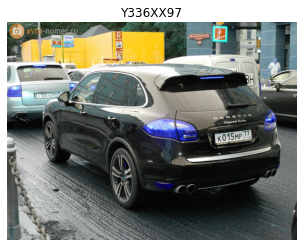

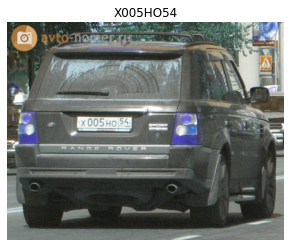

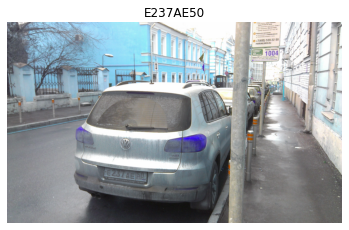

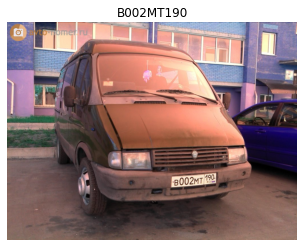

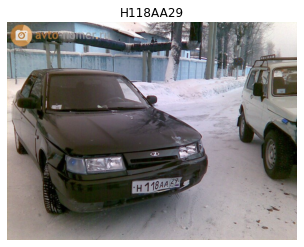

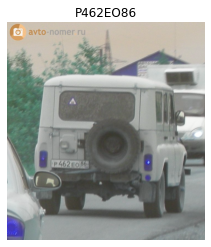

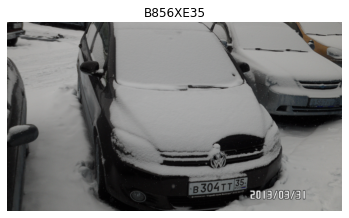

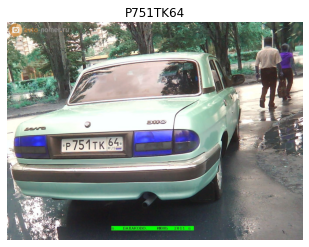

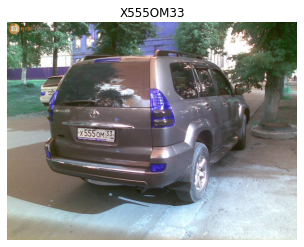

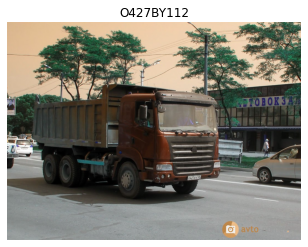

In [40]:
visualize_result(10)